In [2]:
import os
os.chdir("..")

import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score   
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler


from sklearn.pipeline import Pipeline
from feature_engine import imputation as mdi

import matplotlib.pyplot as plt
import seaborn as sns
import shap

from hyperopt import fmin, tpe, Trials
from hyperopt import STATUS_OK

import lightgbm as lgb
import xgboost as xgb
from base.base import load_trainset, load_testset
from base import util

In [3]:
X_train, y_train = load_trainset(mode = 'local')
X_test, y_test = load_testset(mode = 'local')

d_train = xgb.DMatrix(X_train, y_train)
d_test = xgb.DMatrix(X_test, y_test)

### Random Forest

In [ ]:
pipe = Pipeline([
                ('imputer', mdi.MeanMedianImputer(imputation_method='median')),
            ])
X_train = pipe.fit_transform(X_train)
X_test =  pipe.transform(X_test)

mdl_rf = RandomForestClassifier(
    random_state= 43,  n_estimators= 300, max_samples = 0.8280, criterion= 'entropy', max_depth= 8, bootstrap= True, class_weight= 'balanced')

mdl_rf.fit(X_train, y_train)

### XGBoost

In [ ]:

# mdl_xgb = pickle.load(open('xgb_mdl_v1.pkl', 'rb'))
params = {'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0.49999999999999994,
 'learning_rate': 0.08203175775371215,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 200,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 43,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': True,
 'missing': 1,
 'subsample': 1}
 
mdl_xgb = xgb.XGBClassifier(**params)

mdl_xgb.fit(X_train, y_train)


In [ ]:
mdl_xgb.set_params(**{'missing': 1})

In [ ]:
pred_test = mdl_rf.predict_proba(X_test)
print('AUC: ',roc_auc_score(y_test, pred_test[:,1]))
print('accuracy_score: ', accuracy_score(y_test,  mdl_rf.predict(X_test)))


In [ ]:
from catboost import CatBoostClassifier

mdl_cat = CatBoostClassifier(iterations=10)
mdl_cat.load_model('catboost_model.bin')

mdl_cat.fit(X_train,  y_train)


In [ ]:
ser_feat_imp_per = pd.Series(res.importances_mean, index = feat_names)

fig, ax = plt.subplots(figsize = (14,10))

ser_feat_imp_per.sort_values(ascending= False).head(10).plot.barh(yerr = res.importances_std[:50])
ax.set_title('Feature importances using permutation on full model')
ax.set_ylabel('Mean accuracy in impurity')
fig.tight_layout()

In [ ]:
# mdl_xgb = pickle.load(open('xgb_mdl_v1.pkl', 'rb'))
params = {'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0.49999999999999994,
 'learning_rate': 0.08203175775371215,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 50,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 43,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': True,
 'missing': 1,
 'subsample': 1}
 

In [ ]:

selected_mdl_scores = []

thresholds = sorted(mdl_xgb.feature_importances_)

for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(mdl_xgb, threshold=thresh, prefit=True)

    # train model
    selection_model = xgb.XGBClassifier(n_jobs = 3)
    selection_model.fit(selection.transform(X_train), y_train)

    # eval model
    prob = selection_model.predict_prob(selection.transform(X_test))[:,1]

    auc = roc_auc_score(y_test, prob)
    selected_mdl_scores.append([thresh, select_X_train.shape[1], auc])

    print("Thresh=%.3f, n=%d, AUC: %.2f%%" % (thresh, select_X_train.shape[1], auc*100.0))



In [ ]:
best_logit_params = {'C': 2.655690779733333, 'penalty': 'l1', 'solver': 'saga', 'class_weight': 'balanced'}

logit_pipe = Pipeline([
        ('imputer', mdi.MeanMedianImputer(imputation_method='median')),
        ('scaler', StandardScaler(with_std= True)),
        ('logit', LogisticRegression(random_state= 43, **best_logit_params))
    ])

logit_pipe.fit(X_train, y_train)


In [ ]:
X_train_preds = logit_pipe.predict_proba(X_train)[:,1]
X_test_preds = logit_pipe.predict_proba(X_test)[:,1]

print('Train roc_auc: ', roc_auc_score(y_train, X_train_preds))
print('Test roc_auc: ', roc_auc_score(y_test, X_test_preds))

In [ ]:
from sklearn.feature_selection import SelectFromModel

median_selector = SelectFromModel(estimator= logit_pipe[2], threshold= 'median' , prefit= True)

median_selector.transform(X_train).shape


In [ ]:
## catboost feature importance 

df_feat_cat = pd.read_excel('feature_importance_catboost.xlsx')
feat_cat_set = set(df_feat_cat[df_feat_cat.PredictionValuesChange > 0]['Feature Id'])
df_feat_cat = df_feat_cat.set_index('Feature Id')


### LightGBM

In [21]:
import optuna
lgb_study = optuna.load_study(study_name= 'lgb_trials_v2', storage = util.sqlite_path)

In [31]:
lgb_study.best_params


{'bagging_fraction': 0.9,
 'bagging_freq': 1,
 'feature_fraction': 0.9,
 'lambda_l1': 25,
 'lambda_l2': 95,
 'learning_rate': 0.2767832168530619,
 'max_depth': 7,
 'min_data_in_leaf': 3900,
 'min_gain_to_split': 2.120872709000934,
 'n_estimators': 348,
 'num_leaves': 1340}

In [34]:
fig = optuna.visualization.plot_optimization_history(lgb_study)
fig.show()


In [33]:
optuna.visualization.plot_contour(
    lgb_study, params = ['bagging_fraction', 'lambda_l1', 'lambda_l2', 'learning_rate'])


In [26]:
lgb_study.best_params

{'bagging_fraction': 0.9,
 'bagging_freq': 1,
 'feature_fraction': 0.9,
 'lambda_l1': 25,
 'lambda_l2': 95,
 'learning_rate': 0.2767832168530619,
 'max_depth': 7,
 'min_data_in_leaf': 3900,
 'min_gain_to_split': 2.120872709000934,
 'n_estimators': 348,
 'num_leaves': 1340}

In [27]:
params = {'bagging_fraction': 0.9,
 'bagging_freq': 1,
 'feature_fraction': 0.9,
 'lambda_l1': 25,
 'lambda_l2': 95,
 'learning_rate': 0.2767832168530619,
 'max_depth': 7,
 'min_data_in_leaf': 3900,
 'min_gain_to_split': 2.120872709000934,
 'n_estimators': 348,
 'num_leaves': 1340}

mdl_lgb = lgb.LGBMClassifier(**params)

# mdl_lgb.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], eval_metric='auc', verbose = 10)
mdl_lgb.fit(
    X_train, y_train, 
    eval_set = [(X_train, y_train), (X_test, y_test)], eval_metric='auc', verbose = 10
    )

X_train_preds = mdl_lgb.predict_proba(X_train)
print('AUC: ',roc_auc_score(y_train, X_train_preds[:,1]))
print('accuracy_score: ', accuracy_score(y_train,  mdl_lgb.predict(X_train)))

X_test_preds = mdl_lgb.predict_proba(X_test)
print('AUC: ',roc_auc_score(y_test, X_test_preds[:,1]))
print('accuracy_score: ', accuracy_score(y_test,  mdl_lgb.predict(X_test)))


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=3900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3900
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=2.120872709000934, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.120872709000934
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[10]	training's auc: 0.763238	training's binary_logloss: 0.246489	valid_1's auc: 0.751738	valid_1's binary_logloss: 0.249196
[20]	training's auc: 0.779563	training's bina

<AxesSubplot: >

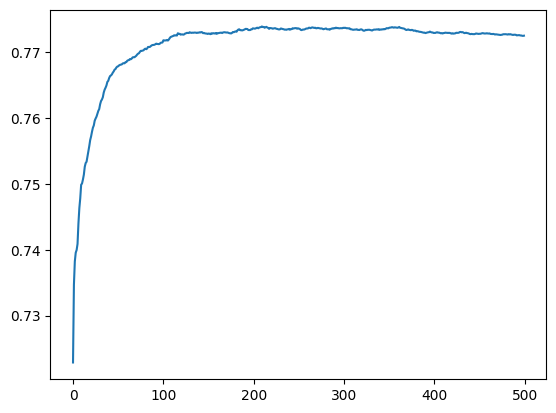

In [18]:
sns.lineplot(mdl_lgb.evals_result_['valid_1']['auc'][:500])

<AxesSubplot: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='auc'>

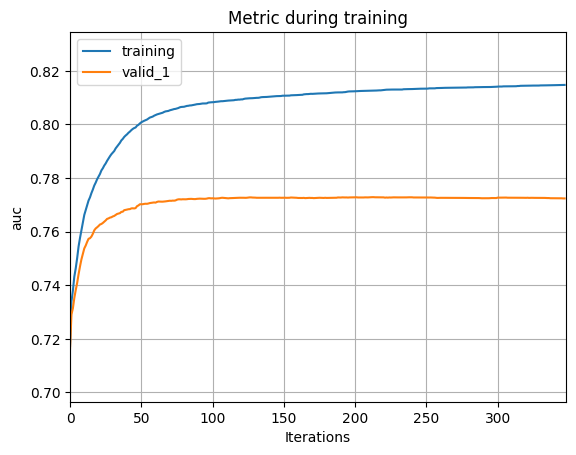

In [28]:
lgb.plot_metric(mdl_lgb, 'auc')

<AxesSubplot: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='auc'>

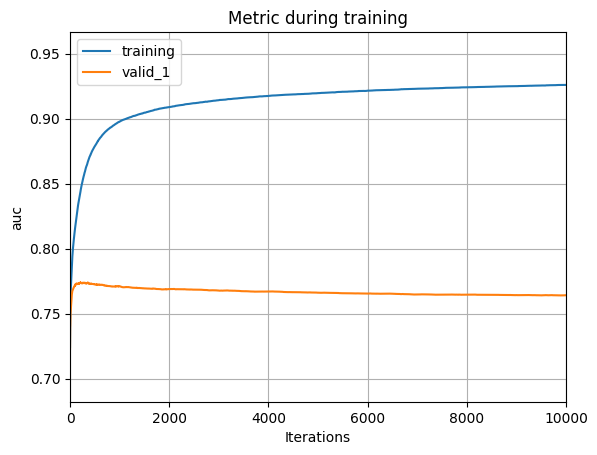

In [5]:
lgb.plot_metric(mdl_lgb, 'auc')

In [ ]:
mdl_dt = DecisionTreeClassifier(random_state= 43, max_depth= 5, class_weight='balanced')

mdl_dt.fit(X_train, y_train)

X_test_preds = mdl_dt.predict_proba(X_test)
print('AUC: ',roc_auc_score(y_test, X_test_preds[:,1]))
print('accuracy_score: ', accuracy_score(y_test,  mdl_dt.predict(X_test)))


### Peformance Combined 

In [ ]:
df_mdl_perf = pd.DataFrame(
    data = {
    'Logistic Ridge': [
        roc_auc_score(y_train, logit_pipe.predict_proba(X_train)[:,1]),
        roc_auc_score(y_test, logit_pipe.predict_proba(X_test)[:,1])
        ],
    'Decision Tree': [
        roc_auc_score(y_train, mdl_dt.predict_proba(X_train)[:,1]),
        roc_auc_score(y_test, mdl_dt.predict_proba(X_test)[:,1])
        ],
    'Random Forest':[ 
        roc_auc_score(y_train, mdl_rf.predict_proba(X_train)[:,1]),
        roc_auc_score(y_test, mdl_rf.predict_proba(X_test)[:,1])
        ],
    'XGBoost': [
        roc_auc_score(y_train, mdl_xgb.predict_proba(X_train)[:,1]),
        roc_auc_score(y_test, mdl_xgb.predict_proba(X_test)[:,1])
        ],
    'Lightgbm': [
        roc_auc_score(y_train, mdl_lgb.predict_proba(X_train)[:,1]),
        roc_auc_score(y_test, mdl_lgb.predict_proba(X_test)[:,1])
        ],
    'Catboost': [
        roc_auc_score(y_train, mdl_cat.predict_proba(X_train)[:,1]),
        roc_auc_score(y_test, mdl_cat.predict_proba(X_test)[:,1])
        ]
    },
    index= ['train_auc', 'test_auc']
).T


In [ ]:
lgb.plot_importance(mdl_lgb, max_num_features= 10)

In [ ]:

df_feat_xgb = pd.DataFrame(
    {
        'feat_name' : feat_names,
        'xgboost': mdl_xgb.feature_importances_
    }
).set_index('feat_name')

df_feat_logit = pd.DataFrame(
    {
        'feat_name': feat_names,
        'logistic': abs(logit_pipe[2].coef_)[0]
    }
).set_index('feat_name')


df_feat_lgb = pd.DataFrame(
    {
        'feat_name': feat_names,
        'lightgbm': mdl_lgb.feature_importances_
    }
).set_index('feat_name')

df_feat_rf = pd.DataFrame(
    {
        'feat_name': feat_names,
        'random_forest': mdl_rf.feature_importances_
    }
).set_index('feat_name')


df_feat_dt = pd.DataFrame(
    {
        'feat_name': feat_names,
        'decision_tree': mdl_dt.feature_importances_
    }
).set_index('feat_name')


df_feat_merge = pd.concat(
    [df_feat_cat.rename(columns = {'LossFunctionChange' : 'catboost'})['catboost'],   # catboost feature importance
     df_feat_xgb['xgboost'],             # xgboost feature importance
     df_feat_lgb['lightgbm'],              # lightgbm feature importance
     df_feat_rf['random_forest'],              # random forest feature importance
     df_feat_logit['logistic'],         # logit rigid cofficient
     df_feat_dt['decision_tree']               # Decision tree feature importance
     ], axis =1,

)


In [ ]:
pd.DataFrame (
    data = df_feat_merge
    index = df_feat_merge.index,
    columns = df_feat_merge.columns
)


In [ ]:
sns.pairplot(
    df_feat_merge
)


In [ ]:
feat_logit_set.difference(feat_xgb_set)

In [ ]:
feat_logit_set.intersection(feat_cat_set)

In [ ]:
df_feat = pd.DataFrame(
    {
        'feat_name' : X.columns,
        'feat_importance': mdl_rf.feature_importances_
    }
)

df_feat

In [ ]:
explainer = shap.Explainer(mdl_xgb)
shap_values = explainer(X_test)


In [254]:
shap.summary_plot(
    shap_values = shap_values,
    features = X_test,
    feature_names = feat_names,
    max_leaves = 15,
)

TypeError: summary_legacy() got an unexpected keyword argument 'max_leaves'

: 

In [ ]:
from sklearn.inspection import permutation_importance

res = permutation_importance(mdl_rf, X_test, y_test, n_repeats = 10, random_state = 43, n_jobs =2 )

In [ ]:
from scipy import stats

stats.describe(mdl_xgb.predict_proba(X_test)[:,1])


### PDP

In [ ]:
from sklearn.inspection import PartialDependenceDisplay


PartialDependenceDisplay.from_estimator(mdl_lgb, X_test,['DAYS_BIRTH'])


In [ ]:
PartialDependenceDisplay.from_estimator(mdl_lgb, X_test,['AMT_ANNUITY', 'EXT_SOURCE_3'])

In [ ]:
PartialDependenceDisplay.from_estimator(mdl_lgb, X_test,['NEW_EXT_SOURCES_MEAN', 'NEW_CREDIT_TO_ANNUITY_RATIO'])

In [ ]:
shap.force_plot(explainer.expected_value[1], shap_values[1][:1000,:], X_test.iloc[:1000,:])


In [ ]:
feat_imp_mdi = mdl_rf.feature_importances_
std = np.std([d_tree.feature_importances_ for d_tree in mdl_rf.estimators_])
ser_feat_imp_mdi = pd.Series(feat_imp_mdi, index = feat_names)

fig, ax = plt.subplots(figsize = (14,10))

ser_feat_imp_mdi.sort_values(ascending= False).head(50).plot.barh(yerr = std)

ax.set_title('Feature importances using MDI')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()

In [ ]:
explainer = shap.TreeExplainer(mdl_lgb)
shap_values = explainer.shap_values(X_test)


#### Visualize a single prediction

In [ ]:
shap.initjs()

In [ ]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_test.iloc[0,:])

In [ ]:
X_test.iloc[0,:]

In [ ]:
shap.force_plot(explainer.expected_value[1], shap_values[1][:100,:], X_test.iloc[:100,:])   

In [ ]:
for name in df_feat_lgb.head(10).index:
    shap.dependence_plot(name, shap_values[1], X_test, display_features=X_test